# Caliban Fig8 Processing Pipeline

In [1]:
# import statements
from __future__ import absolute_import

import numpy as np
import os
import stat
import sys
import copy


import skimage.io as io
from imageio import imread, volread, imwrite, volwrite
from ipywidgets import fixed, interactive

from caliban_toolbox.pre_annotation import npz_preprocessing
from caliban_toolbox.post_annotation import npz_postprocessing
from caliban_toolbox.pre_annotation.aws_upload import aws_caliban_upload
from caliban_toolbox.pre_annotation.caliban_csv import initial_csv_maker, create_next_CSV
from caliban_toolbox.pre_annotation.fig_eight_upload import fig_eight
from caliban_toolbox.utils.io_utils import get_img_names
from caliban_toolbox.utils import widget_utils

from segmentation.utils import data_utils
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import filters, img_as_uint
perm_mod = stat.S_IRWXO | stat.S_IRWXU | stat.S_IRWXG

## Load data for model training
We'll specify which channels will be used to generate preliminary labels for the model


In [ ]:
# 3D data example:
# data_dir = '/example_data/3D/FOV_0'
# data_vol = os.path.join(data_dir, 'Pos0_DAPIRegistered.tif')
# data_stack_values = volread(data_vol)
# data_stack_values = np.expand_dims(data_stack_values, axis=-1)


# # convert to xarray
# fov_names = ["slice_" + str(x) for x in range(data_stack_values.shape[0])]
# channel_names = ["DAPI"]
# data_stack_xr = xr.DataArray(data_stack_values, coords=[fov_names, range(data_stack_values.shape[1]),
#                                                 range(data_stack_values.shape[2]), channel_names],
#                             dims=["fovs", "rows", "cols", "channels"])

In [8]:
# time series data example
data_stack_xr = data_utils.load_imgs_from_dir("/example_data/timelapse/HeLa_by_image", load_axis="stacks",
                                              imgs=["FITC_001.png", "Phase_000.png", "Phase_001.png", "Phase_002.png"])

In [ ]:
# # mibi data example
# data_stack_xr = data_utils.load_tifs_from_points_dir("/example_data/multichannel/Training_Data_1")

In [3]:
# initialize lists to hold newly created channels
adjusted_channels, adjusted_channel_names, adjusted_channel_kwargs = [], [], []

# initialize lists to hold newly created channels
overlay_channels, overlay_channel_names, overlay_channel_kwargs = [], [], []

## Run the data through the network to produce labels

In [ ]:
# deepcell upload code here

## Postprocess the deepcell labels

In [ ]:
# code to postprocess labels, select appropriate parameters

# Part A: Adjust image contrast, background, thresholding

### Step 1: Pick raw image
This will be used as an example to display effect of adjustments later on. This can be changed at any time!

In [4]:
choose_img_output = interactive(widget_utils.choose_img_from_stack, stack = fixed(data_stack_xr), 
                         slice_idx = (0, data_stack_xr.shape[0]-1, 1),
                         chan_name = (data_stack_xr.channels.values));
choose_img_output

interactive(children=(IntSlider(value=2, description='slice_idx', max=4), Dropdown(description='chan_name', op…

### Step 2: Set raw image adjust parameters
These will be held in memory until npz is saved. A record of the contrast adjustment settings will be saved with them.

In [5]:
# get most recent parameters for selected image
selected_slice_idx, selected_channel_idx = choose_img_output.result
img = data_stack_xr[selected_slice_idx, :, :, selected_channel_idx]

# interative edit mode
adjust_image_output = interactive(widget_utils.adjust_image_interactive, image=fixed(img), blur=(0.0,4,0.1), 
                       gamma_adjust=(0.1,4,0.1), sobel_factor=(10,10000,100), v_min = (0, 255, 1), 
                       v_max = (0, 255, 1));
adjust_image_output

interactive(children=(FloatSlider(value=1.0, description='blur', max=4.0), Checkbox(value=True, description='s…

### Step 3: Adjust raw image with specified parameters

In [6]:
# create placeholder channel to hold the output of channel adjustment
adjusted_channel_xr = xr.DataArray(np.zeros(data_stack_xr.shape[:-1] + (1,), np.uint8),
                                   coords=[data_stack_xr.points, data_stack_xr.rows, data_stack_xr.cols,
                                          ["adjusted_channel"]],
                                   dims=data_stack_xr.dims)

# adjust all slices for given channel
for i in range(data_stack_xr.shape[0]):
    image = data_stack_xr[i, :, :, selected_channel_idx]
    adjusted_channel_xr[i, :, :, 0] = widget_utils.adjust_image(image, adjust_image_output.kwargs)

### Step 4: Verify that adjustment looks good across slices

In [7]:
check_adjustment_output = interactive(widget_utils.choose_img_from_stack, stack = fixed(adjusted_channel_xr), 
                               slice_idx = (0, data_stack_xr.shape[0]-1, 1),
                              chan_name = fixed("adjusted_channel"));
check_adjustment_output

interactive(children=(IntSlider(value=2, description='slice_idx', max=4), Output()), _dom_classes=('widget-int…

### Step 5: Give the adjusted channel an informative name, repeat part A for each channel that needs to be adjusted

In [8]:
adjusted_channel_name = "Phase_Adjusted"
adjusted_channel_names.append(adjusted_channel_name)
adjusted_channels.append(adjusted_channel_xr.values)
adjusted_channel_kwargs.append(adjust_image_output.kwargs)

# Part B: create overlays

### Step 1: Pick raw image
This will be used as an example to display effect of adjustments later on. This can be changed at any time!

In [9]:
choose_img_output = interactive(widget_utils.choose_img_from_stack, stack = fixed(data_stack_xr), 
                         slice_idx = (0, data_stack_xr.shape[0]-1, 1),
                         chan_name = (data_stack_xr.channels.values));
choose_img_output

interactive(children=(IntSlider(value=2, description='slice_idx', max=4), Dropdown(description='chan_name', op…

### Step 2: Select first channel to be included in overlay, perform any needed adjustments

In [10]:
# available channels
data_stack_xr.channels.values

array(['FITC_001', 'Phase_000', 'Phase_001', 'Phase_002'], dtype='<U9')

In [12]:
img_1_idx = 0
selected_slice_idx, selected_channel_idx = choose_img_output.result
img1 = data_stack_xr[selected_slice_idx, :, :, img_1_idx]

adjust_overlay_1_output = interactive(widget_utils.adjust_image_interactive, image=fixed(img1), blur=(0.0,4,0.1), 
                          gamma_adjust=(0.1,4,0.1), sobel_factor=(10,10000,100), v_min = (0, 255, 1), 
                          v_max = (0, 255, 1));
adjust_overlay_1_output

interactive(children=(FloatSlider(value=1.0, description='blur', max=4.0), Checkbox(value=True, description='s…

### Step 2: Select second channel to be included in overlay, perform any needed adjustments

In [13]:
img_2_idx = 3
img2 = data_stack_xr[selected_slice_idx, :, :, img_2_idx]

adjust_overlay_2_output = interactive(widget_utils.adjust_image_interactive, image=fixed(img2), blur=(0.0,4,0.1), 
                          gamma_adjust=(0.1,4,0.1), sobel_factor=(2,10000,100), v_min = (0, 255, 1), 
                          v_max = (0, 255, 1));
adjust_overlay_2_output

interactive(children=(FloatSlider(value=1.0, description='blur', max=4.0), Checkbox(value=True, description='s…

### Step 3: Select the appropriate settings for combinging the two images together

In [14]:
overlay_images_output = interactive(widget_utils.overlay_images_interactive, 
                               img_1 = fixed(adjust_overlay_1_output.result), 
                               img_2 = fixed(adjust_overlay_2_output.result), 
                               prop_img_1 =(0,1.0, 0.1), v_min = (0, 255, 1), v_max = (0, 255, 1))
overlay_images_output

interactive(children=(FloatSlider(value=0.5, description='prop_img_1', max=1.0), IntSlider(value=0, descriptio…

### Step 4: Create overlays across the whole image stack

In [15]:
# extract settings from interactive job
combined_settings = overlay_images_output.kwargs
prop_img_1 = combined_settings['prop_img_1']
v_min = combined_settings['v_min']
v_max = combined_settings['v_max']

overlay_channel_xr = xr.DataArray(np.zeros(data_stack_xr.shape[:-1] + (1,), np.uint8),
                                   coords=[data_stack_xr.points, data_stack_xr.rows, data_stack_xr.cols,
                                          ["overlay_channel"]],
                                   dims=data_stack_xr.dims)

# apply settings across images in stack
for i in range(data_stack_xr.shape[0]):
    image1 = data_stack_xr[i, :, :, img_1_idx]
    image2 = data_stack_xr[i, :, :, img_2_idx]

    image1_adjusted = widget_utils.adjust_image(image1, adjust_overlay_1_output.kwargs)
    image2_adjusted = widget_utils.adjust_image(image2, adjust_overlay_2_output.kwargs)
    overlay_channel_xr[i, :, :, 0] = widget_utils.overlay_images(image1_adjusted, image1_adjusted, 
                                                              prop_img_1, v_min, v_max)

In [16]:
check_adjustment = interactive(widget_utils.choose_img_from_stack, stack = fixed(overlay_channel_xr), 
                         slice_idx = (0, data_stack_xr.shape[0]-1, 1),
                         chan_name = fixed("overlay_channel"));
check_adjustment

interactive(children=(IntSlider(value=2, description='slice_idx', max=4), Output()), _dom_classes=('widget-int…

### Step 5: Give the combined channel an informative name, repeat part B for each set of overlays that needs to be constructed

In [17]:
# give this overlay an informative name
overlay_channel_name = "phase_0_phase_3_overlay"

# add metadata to list
overlay_channel_names.append(overlay_channel_name)
overlay_channels.append(overlay_channel_xr.values)
adjusted_channel_kwargs.append([prop_img_1, v_min, v_max, adjust_overlay_1_output.kwargs, adjust_overlay_2_output])

# Part C: Determine which modified channels will be included and in what order

In [18]:
# concatenate all adjusted channels together
if len(adjusted_channels) > 0:
    adjusted_channel_stack = np.concatenate(adjusted_channels, axis=-1)
else:
    # blank array in case no channels were adjusted
    adjusted_channel_stack = np.array([]).reshape(data_stack_xr.shape[:-1] + (0,))

    
# concatenate all overlayed channels together
if len(overlay_channels) > 0:
    overlay_channel_stack = np.concatenate(overlay_channels, axis=-1)
else:
    # blank array in case no overlays were created
    overlay_channel_stack = np.array([]).reshape(data_stack_xr.shape[:-1] + (0,))

In [19]:
# combine original channels and new channels together
all_channel_stack = np.concatenate((data_stack_xr.values, adjusted_channel_stack, overlay_channel_stack), axis=-1)
all_channel_names = np.concatenate((data_stack_xr.channels.values, 
                                    adjusted_channel_names, overlay_channel_names), axis=0)
all_channel_names

array(['FITC_001', 'Phase_000', 'Phase_001', 'Phase_002',
       'Phase_Adjusted', 'phase_0_phase_3_overlay'], dtype='<U23')

In [20]:
# create labeled xarray to hold all data
all_channels = xr.DataArray(all_channel_stack, coords=[data_stack_xr.points, data_stack_xr.rows,
                                                      data_stack_xr.cols, all_channel_names],
                           dims=["points", "rows", "cols", "channels"])

In [23]:
# specify subset of above channels to be incldued, as well as their ordering
channel_order = ["FITC_001", "Phase_000", "Phase_002", "Phase_Adjusted"]

In [24]:
channel_xr = data_utils.reorder_xarray_channels(channel_order=channel_order, channel_xr=all_channels)

In [ ]:
# # if segmentation labels are not already part of xarray, load them now
# labels_xr = xr.open_dataarray(os.path.join(base_dir, "segmentation_labels.xr"))
# combined_xr = data_utils.combine_xarrays((channel_xr, labels_xr), axis=-1)

In [75]:
# otherwise, append a blank tif for contouring without a predicted model output
labels_xr = xr.DataArray(np.zeros((channel_xr.shape[:-1] + (1,))), coords=[channel_xr.points, channel_xr.rows,
                                                                           channel_xr.cols, ["segmentation_labels"]],
                        dims=["points", "rows", "cols", "channels"])

combined_xr = data_utils.combine_xarrays((channel_xr, labels_xr), axis=-1)

In [27]:
# For RGB mode, determine color for each channel

In [28]:
print(combined_xr.channels.values[:-1])

['FITC_001' 'Phase_000' 'Phase_002' 'Phase_Adjusted']


In [ ]:
# specify a color for each channel. Available options are: red, green, blue, cyan, magenta, yellow
plot_colors = ["green", "blue"]
combined_xr = set_channel_colors(combined_xr=combined_xr, plot_colors=plot_colors)

# Part D: Set shape of NPZ files for optimum annotator ease

### Crop array into overlapping x and y crops
Split an array up into smaller crops that overlap one another

#### Check crop size
First set parameters to check that crop size and overlap are appropriate

In [79]:
# size of crop
crop_size = (480, 480)

# fraction of crop that will overlap with adjacent crops
overlap_frac = 0.1

# index of channel in npz to visualize
channels_idx = 1

# where crops will get saved
save_dir = "/example_data/timelapse/HeLa_by_image/crop_dir"

In [80]:
cropped_stack_test, log_data_test = npz_preprocessing.crop_multichannel_data(data_xr=combined_xr, 
                                                                             folder_save=save_dir, 
                                                 crop_size=crop_size, overlap_frac=overlap_frac, 
                                                 blank_labels="skip", save_format="xr", relabel=True, 
                                                 test_parameters=True)

renaming from points to fovs


Next we'll add in line overlays for easier visualization

In [81]:
# extract information about test crop dimensions
row_start, row_end  = log_data_test["row_start"], log_data_test["row_end"]
col_start, col_end = log_data_test["col_start"], log_data_test["col_end"]

# get a single crop from the stack of cropped images
example_crop = cropped_stack_test[0, 3, :, :, channels_idx]

# load the first image from the xarray stack, which is the one that the crops were generated from
example_img = copy.deepcopy(combined_xr[0, ...])

In [82]:
example_img_overlay = npz_postprocessing.overlay_grid_lines(overlay_img=example_img[:, :, channels_idx], 
                                                           row_start=row_start, 
                                 row_end=row_end, col_start=col_start, col_end=col_end)

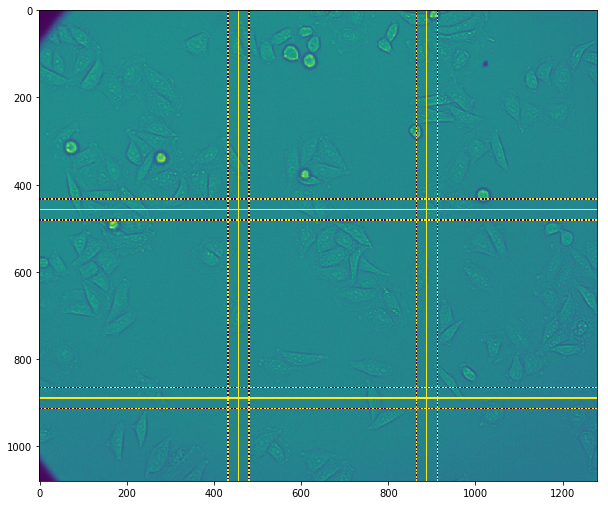

In [83]:
plt.figure(figsize = (10, 10))
plt.imshow(example_img_overlay[:, :])

In [84]:
img_crop_overlay = npz_postprocessing.overlay_crop_overlap(img_crop=example_crop.values, row_start=row_start, 
                                                           row_end=row_end,
                                       col_start=col_start, col_end=col_end)

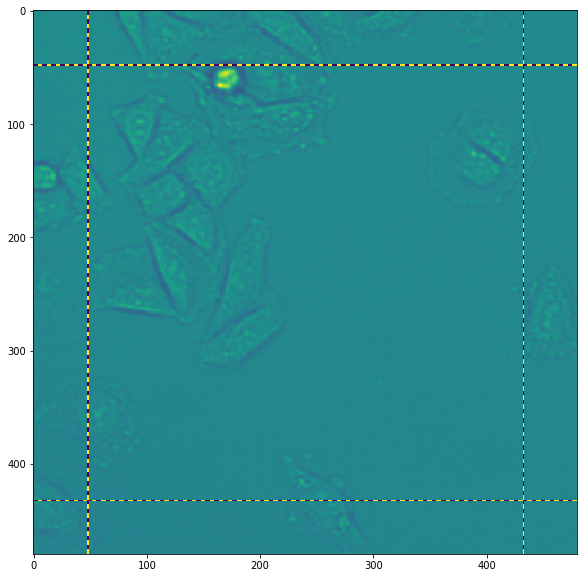

In [85]:
plt.figure(figsize = (10, 10))
plt.imshow(img_crop_overlay)

In [ ]:
# once the parameters above look good, we'll crop the images
npz_preprocessing.crop_multichannel_data(data_xr=combined_xr, folder_save=save_dir, 
                                                 crop_size=crop_size, overlap_frac=overlap_frac, 
                                                 blank_labels="include", save_format="npz", relabel=True, 
                                                 test_parameters=False)

In [ ]:
# if using predicted segmentations, save overlay to double check appropriate settings used
plot_utils.plot_overlay(combined_xr[0, :, :, -1].values, plotting_tif=combined_xr[0, :, :, [0, 1, 4]].values)
                        #path=os.path.join(base_dir, "overlay.tiff"))


### Create montages across 3D or timelapse slices

In [64]:
# first add in any missing dimensions to standardize format
reshaped_xr = npz_postprocessing.reshape_xr(final_xr, ["fovs", "points", "rows", "cols", "channels",])

# determine how many slices per montage
montage_slice_len = 2

montage_xr, montage_indices = npz_preprocessing.create_montage_data(reshaped_xr, montage_slice_len)
npz_preprocessing.save_npzs_for_caliban(montage_xr, montage_indices, "/example_data/timelapse/HeLa_by_image_montaged")

### Relabel npzs -- recommended for fig8 first pass jobs
"Predict" relabeling is recommended (unless 3D segmentation models are being used), since this relabeling strategy will perform decently on most 3D data to reduce the human labor involved in correction.

In [ ]:
# not sure what this is for?
# relabel_npzs_folder(npz_dir = sliced_save_dir, relabel_type = 'predict')